In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
    Created on Tue May 28 2024
    
    @author: Yaning
"""

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
import pyro.distributions as dist
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
import seaborn as sns

# np.random.seed(123)
# torch.manual_seed(123)

%run Documents/pyro_models/files_to_run/data_analysis_without_version.ipynb
# %run Documents/pyro_models/files_to_run/data_analysis(matlab_dataset).ipynb


['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


/tmp/ipykernel_2203712/2314349868.py:24: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
trial_num = data.shape[-2]
info_num = data.shape[-1]

real_data = data.reshape(60,trial_num,info_num)
# real_data = data[1]

In [49]:
real_data = data[1,[0, 2, 3, 5, 6, 7, 9, 10, 12, 14, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28]]

In [3]:
real_data.shape

(30, 170, 8)

In [3]:
real_data = torch.tensor(real_data)

In [4]:
# np.random.seed(123)
# torch.manual_seed(123)

# beta_variance = lambda alpha, beta: alpha*beta / ((alpha+beta)**2 * (alpha + beta + 1))
# gamma_variance = lambda conc, rate: conc/(rate**2)

# device = torch.device("cpu")

# torch.set_default_tensor_type(torch.DoubleTensor)


def model(data):
    # sigma_es = (1-nova)a*e^(b*delay) + nova*c (as in constant)
    # in the order of 
    # 0:mean_u
    # 1:log_sigma_u
    # 2:log_a
    # 3:log_b
    # 4:log_c (the power of delay)
    # 5:log_beta

    num_params = 6
    num_agents = data.shape[0]
    num_trials = data.shape[1]
    # define hyper priors over model parameters
    # prior over sigma of a Gaussian is a Gamma distribution
    a = pyro.param('a', torch.ones(num_params), constraint=dist.constraints.positive)
    lam = pyro.param('lam', torch.ones(num_params), constraint=dist.constraints.positive)
    tau = pyro.sample('tau', dist.Gamma(a, a/lam).to_event(1)) # mean = a / (a/lam) = lam

    sig = pyro.deterministic('sig', 1/torch.sqrt(tau)) # Gauss sigma

    # each model parameter has a hyperprior defining group level mean
    # in the form of a Normal distribution
    m = pyro.param('m', torch.zeros(num_params))
    s = pyro.param('s', torch.ones(num_params), constraint=dist.constraints.positive)
    mu = pyro.sample('mu', dist.Normal(m, s*sig).to_event(1)) # Gauss mu, wieso s*sig?

    # in order to implement groups, where each subject is independent of the others, pyro uses so-called plates.
    # you embed what should be done for each subject into the "with pyro.plate" context
    # the plate vectorizes subjects and adds an additional dimension onto all arrays/tensors
    # i.e. p1 below will have the length num_agents
    with pyro.plate('ag_idx', num_agents):
        # draw parameters from Normal and transform (for numeric trick reasons)
        base_dist = dist.Normal(0., 1.).expand_by([num_params]).to_event(1)
        # Transform via the pointwise affine mapping y = loc + scale*x (-> Neal's funnel)
        transform = dist.transforms.AffineTransform(mu, sig) 
        locs = pyro.sample('locs', dist.TransformedDistribution(base_dist, [transform]))

    group_indices = torch.arange(num_agents).unsqueeze(1).repeat(1, num_trials).reshape(-1)
    with pyro.plate('data', num_agents*num_trials):
        mean_u = locs[:,0][group_indices]
        sigma_u = torch.exp(locs[:,1])[group_indices]
        # sigma_es = torch.exp(locs[:,2])[group_indices]
        a = torch.exp(locs[:,2])[group_indices]
        b = torch.exp(locs[:,3])[group_indices]
        # c = torch.exp(locs[:,5])[group_indices]
        beta = torch.exp(locs[:,4])[group_indices]

        delay = 1/(1+b*torch.exp(-a*data[:,:,2].view(-1)))
        # delay = a/(1+b/data[:,:,2].view(-1))
        
        e_mean = (mean_u*delay**2 + 
                 data[:,:,3].view(-1)*sigma_u**2)/(delay**2 + sigma_u**2)
        e_sigma = ((sigma_u**2*delay**2)/(sigma_u**2 + delay**2))**0.5

        e_dist  = dist.Normal(e_mean, e_sigma)
        pos = 1 - e_dist.cdf(torch.tensor(20.))
        softmax_args = torch.stack([beta*pos, beta*(1-pos)])
        p = torch.softmax(softmax_args, dim = 0)[0]
        pyro.sample("obs", dist.Bernoulli(probs = p), obs=data[:,:,4].view(-1))
    # return locs
            

In [5]:
def guide(data):
    num_params = 5
    num_agents = data.shape[0]
    # biject_to(constraint) looks up a bijective Transform from constraints.real 
    # to the given constraint. The returned transform is guaranteed to have 
    # .bijective = True and should implement .log_abs_det_jacobian().
    trns = torch.distributions.biject_to(dist.constraints.positive)

    # define mean vector and covariance matrix of multivariate normal
    m_hyp = pyro.param('m_hyp', torch.zeros(2*num_params))
    st_hyp = pyro.param('scale_tril_hyp',
                    torch.eye(2*num_params),
                    constraint=dist.constraints.lower_cholesky)

    # set hyperprior to be multivariate normal
    # scale_tril (Tensor) – lower-triangular factor of covariance, with positive-valued diagonal
    hyp = pyro.sample('hyp',
                    dist.MultivariateNormal(m_hyp, scale_tril=st_hyp),
                    infer={'is_auxiliary': True})

    # mu & tau unconstrained
    unc_mu = hyp[..., :num_params]
    unc_tau = hyp[..., num_params:]

    # constrained tau, shape num_params, or num_particles, 1, num_params
    c_tau = trns(unc_tau)

    # ld = log_density
    # log_abs_det_jacobian(x, y) computes derivative |dy/dx|
    ld_tau = -trns.inv.log_abs_det_jacobian(c_tau, unc_tau)
    
    # sum_rightmost(x, dim)
    # sum out ``dim`` many rightmost dimensions of a given tensor.
    # ld_tau.shape is num_params, or num_particles, 1, num_params before sum_rightmost
    ld_tau = dist.util.sum_rightmost(ld_tau, ld_tau.dim() - c_tau.dim() + 1)

    # some numerics tricks
    mu = pyro.sample("mu", dist.Delta(unc_mu, event_dim=1))
    # c_tau shape: num_params, or num_particles, 1, num_params
    # ld_tau shape: [] or num_particles, 1,
    tau = pyro.sample("tau", dist.Delta(c_tau, log_density=ld_tau, event_dim=1))

    m_locs = pyro.param('m_locs', torch.zeros(num_agents, num_params))
    st_locs = pyro.param('scale_tril_locs',
                    torch.eye(num_params).repeat(num_agents, 1, 1),
                    constraint=dist.constraints.lower_cholesky)
    
    with pyro.plate('ag_idx', num_agents):
        locs = pyro.sample("locs", dist.MultivariateNormal(m_locs, scale_tril=st_locs))

    return {'tau': tau, 'mu': mu, 'locs': locs, 'm_locs': m_locs, 'st_locs': st_locs}

/home/yaning/Documents/python_env/pyro/lib/python3.11/site-packages/torch/random.py:157: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


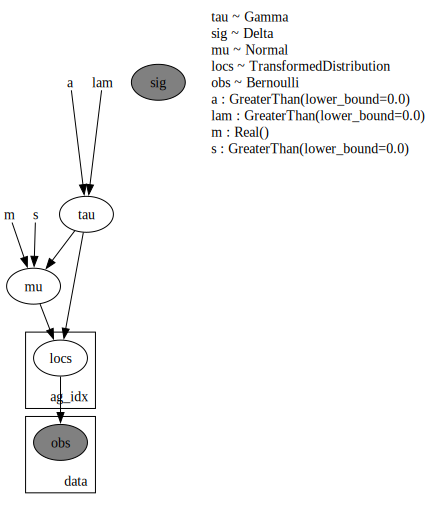

In [6]:
pyro.render_model(model, model_args=(real_data,), render_params=True, render_distributions=True)

Mean ELBO 1481.55: 100%|█████████████████████████████████████| 10000/10000 [00:53<00:00, 187.54it/s]


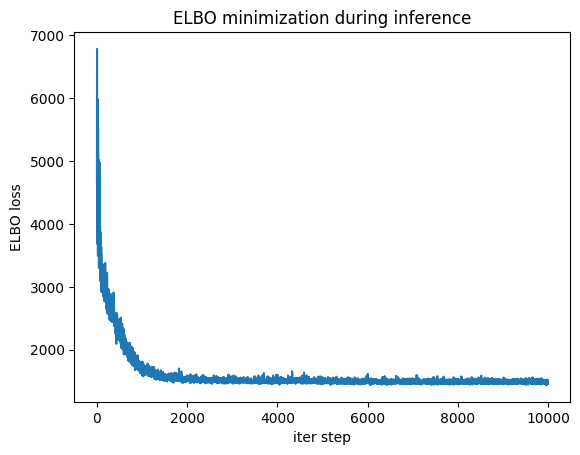

In [16]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 10000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(real_data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [17]:
pos_dict = {}
for name, value in pyro.get_param_store().items():
    pos_dict[name] = value

# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {key: value.detach().numpy() for key, value in pos_dict.items()}

In [12]:
results = pyro.get_param_store()['m_locs']

In [18]:
# save the dictionary
with open('Documents/pyro_models/files_to_run/results/logistic_ohne_sigma_es_and_c_gamble.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)

In [20]:
results = results.detach().numpy()

In [19]:
sample_num = 1000
tau = []
mu = []
locs = []
for i in range(sample_num):
    tau.append(guide(real_data)['tau'].detach().numpy())
    mu.append(guide(real_data)['mu'].detach().numpy())
    locs.append(guide(real_data)['locs'].detach().numpy())

In [20]:
tau = np.array(tau)
mu = np.array(mu)
locs = np.array(locs)

In [21]:
sample_dict = {}
sample_dict['tau'] = tau
sample_dict['mu'] = mu
sample_dict['locs'] = locs

In [22]:
# save the dictionary
with open('Documents/pyro_models/files_to_run/results/logistic_ohne_sigma_es_and_c_gamble_samples_locs.pkl', 'wb') as f:
    pickle.dump(sample_dict, f)

<Axes: ylabel='Density'>

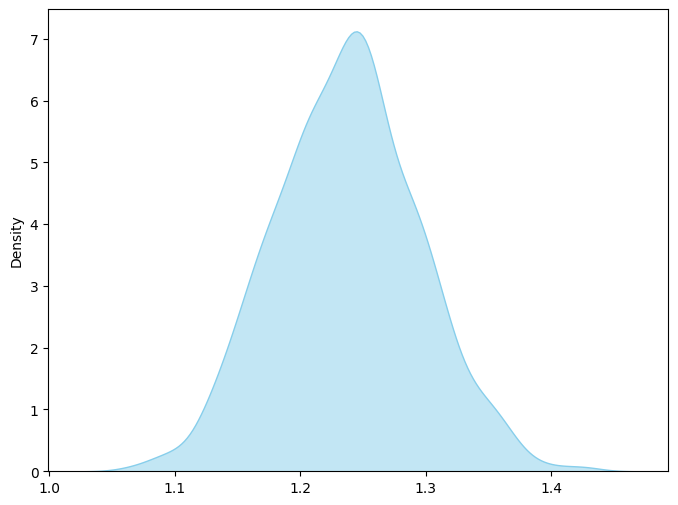

In [55]:
plt.figure(figsize=(8, 6))
sns.kdeplot(mu[:,6], fill=True, color='skyblue', alpha=0.5)

{'tau': tensor([ 0.1178,  2.2012,  3.2820,  0.7222,  0.4080,  0.9966, 10.0098],
        grad_fn=<ExpandBackward0>),
 'mu': tensor([2.1906, 1.6761, 1.7347, 0.6508, 3.3763, 1.6947, 1.2202],
        grad_fn=<ExpandBackward0>),
 'locs': tensor([[ 4.0719e+00,  2.1196e+00,  1.8312e+00, -8.6365e-01,  1.6567e+00,
           1.4975e+00,  1.8424e+00],
         [ 5.4623e-01,  1.2691e+00,  1.8778e+00,  8.5375e-01,  4.6758e+00,
           9.9061e-01,  1.5489e+00],
         [ 3.7862e+00,  1.4087e+00,  1.1279e+00, -5.1862e-01,  3.1005e+00,
           1.9392e+00,  8.7978e-01],
         [ 3.1776e+00,  2.3516e+00,  8.8700e-01, -2.0281e-01,  1.0709e+00,
           3.1215e+00,  1.6291e+00],
         [ 3.4505e-01,  1.7521e+00,  2.1827e+00, -1.2922e+00,  3.7532e+00,
           4.7624e-01,  1.2633e+00],
         [ 2.5479e+00,  2.5411e+00,  5.8559e-02,  2.5049e+00,  1.0547e+00,
           1.5965e+00,  9.4799e-01],
         [ 5.6377e+00,  1.0816e+00,  1.6445e+00,  2.2938e+00,  4.0900e+00,
           1.6802e+00